In [1]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import random
from typing import List
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB

import torchaudio

import torch

In [2]:
# integrate all data paths together

parent_directory='../../data/train'

sub_folders=glob.glob(os.path.join(parent_directory,'*'))

files=[]

for folder_path in sub_folders:
    first_file=glob.glob(os.path.join(folder_path,'*.ogg'))
    files.extend(first_file)

In [3]:
print(len(files))
print(files[0])

12
../../data/train/ashpri1/XC116339.ogg


In [4]:
def read_audio(path: str):
    """
    Read an OGG file using torchaudio and return the waveform tensor and sample rate.

    Parameters:
        path: Path to the .ogg file

    Returns:
        waveform: Tensor representing the waveform
        sample_rate: Sample rate of the audio file
    """
    audio, sample_rate = torchaudio.load(path)
    return audio, sample_rate


In [5]:
audio, sr=read_audio(path=files[0])

print(audio)
print(audio.shape)
print(sr)

tensor([[-3.1757e-05,  9.0428e-06, -4.9695e-06,  ..., -3.7363e-05,
          2.9500e-05, -2.9969e-05]])
torch.Size([1, 206472])
32000


In [6]:
a=audio[:,200000:]

a.shape

torch.Size([1, 6472])

In [7]:
def audio_info(audio: torch.Tensor, sample_rate: int):
    """
    Grab all information of the input audio loaded by torchaudio.

    Parameters:
        audio: Tensor representing the waveform
        sample_rate: Sample rate of the audio file

    Return:
        duration_seconds: Duration of the audio in seconds
        num_channels: Number of audio channels
    """
    # The audio duration time (seconds)
    duration_seconds = audio.shape[1] / sample_rate

    # The number of channels
    num_channels = audio.shape[0]


    return duration_seconds, num_channels

In [8]:
duration_seconds, num_channels=audio_info(audio=audio, sample_rate=sr)

print(duration_seconds)
print(num_channels)


6.45225
1


In [9]:
import torch
import torchaudio
from typing import List

def slice_audio_5_align(audio: torch.Tensor, sample_rate: int) -> List[torch.Tensor]:
    """
    Slice the complete audio tensor into multiple 5 seconds length,
    keep all slices having the same length, especially for the last slice.

    Parameters:
        audio: Tensor representing the waveform of the audio.
        sample_rate: The sample rate of the audio file.

    Returns:
        segments: List of tensors, each representing a 5-second audio segment.
    """
    # Set up the segment duration in samples
    segment_duration = 5 * sample_rate  # 5 seconds in number of samples

    # Total number of samples in the waveform
    total_samples = audio.shape[1]

    # Check if the audio is less than 5 seconds
    if total_samples < segment_duration:
        # Calculate the required padding length
        padding_length = segment_duration - total_samples
        # Create a tensor of zeros (silence) for padding
        silence = torch.zeros(audio.shape[0], padding_length)
        # Pad the waveform with silence
        padded_waveform = torch.cat([audio, silence], dim=1)
        return [padded_waveform]  # Return the padded waveform as a single segment

    # If the audio is 5 seconds or longer, proceed as normal
    segments = [audio[:, i:i + segment_duration] for i in range(0, total_samples, segment_duration)]

    # Ensure the last segment is exactly 5 seconds long
    if segments[-1].shape[1] != segment_duration:
        # Extract the last segment_duration samples to ensure it's 5 seconds long
        last_segment = audio[:, -segment_duration:]
        segments[-1] = last_segment  # Replace the last segment with a full 5-second segment

    return segments


In [10]:
slice_5_test=slice_audio_5_align(audio=audio,sample_rate=sr)

print(slice_5_test)
print(type(slice_5_test))
print(len(slice_5_test))

print(slice_5_test[0].shape)
print(slice_5_test[1].shape)
print(type(slice_5_test[0]))

[tensor([[-3.1757e-05,  9.0428e-06, -4.9695e-06,  ..., -7.8678e-03,
         -1.0882e-02,  4.8679e-04]]), tensor([[ 8.4661e-03,  1.2342e-02,  1.5018e-02,  ..., -3.7363e-05,
          2.9500e-05, -2.9969e-05]])]
<class 'list'>
2
torch.Size([1, 160000])
torch.Size([1, 160000])
<class 'torch.Tensor'>


torch.Size([1, 40, 251])
<class 'torch.Tensor'>
torch.Size([40, 251])


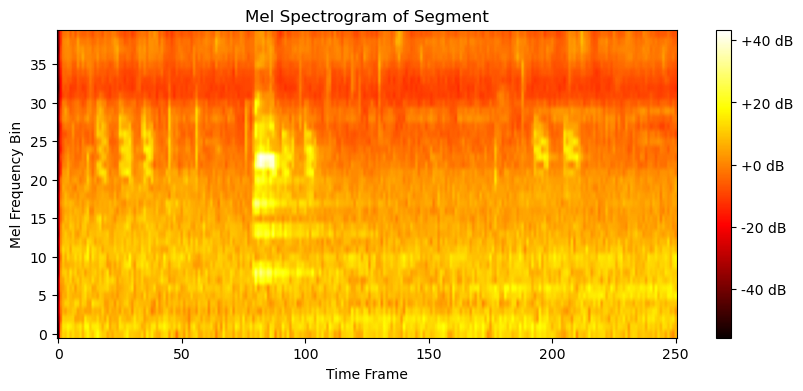

In [11]:

window_size = 0.04  
hop_size = 0.02   
n_fft = int(window_size * sr)  
hop_length = int(hop_size * sr) 

n_mels = 40  

mel_transform = MelSpectrogram(
    sample_rate=sr,
    n_fft=n_fft,
    hop_length=hop_length,
    n_mels=n_mels,
    f_min=0,
    f_max=16000
)

db_transform = AmplitudeToDB()


mel_spectrogram = mel_transform(slice_5_test[0])
print(mel_spectrogram.shape)
print(type(mel_spectrogram))
print(mel_spectrogram[0].shape)
mel_spectrogram_db = db_transform(mel_spectrogram)

plt.figure(figsize=(10, 4))
plt.imshow(mel_spectrogram_db[0].numpy(), cmap='hot', origin='lower', aspect='auto')
plt.title(f'Mel Spectrogram of Segment')
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Time Frame')
plt.ylabel('Mel Frequency Bin')
plt.show()

torch.Size([1, 40, 251])


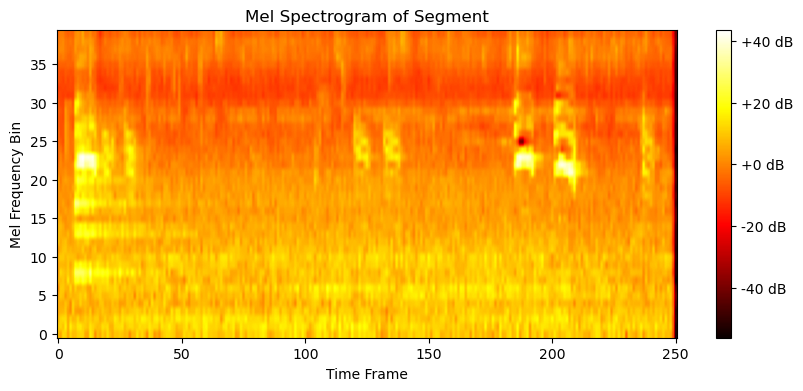

In [12]:
mel_transform = MelSpectrogram(
    sample_rate=sr,
    n_fft=n_fft,
    hop_length=hop_length,
    n_mels=n_mels,
    f_min=0,
    f_max=16000
)

db_transform = AmplitudeToDB()


mel_spectrogram = mel_transform(slice_5_test[1])
print(mel_spectrogram.shape)
mel_spectrogram_db = db_transform(mel_spectrogram)


plt.figure(figsize=(10, 4))
plt.imshow(mel_spectrogram_db[0].numpy(), cmap='hot', origin='lower', aspect='auto')
plt.title(f'Mel Spectrogram of Segment')
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Time Frame')
plt.ylabel('Mel Frequency Bin')
plt.show()